In [1]:
import sys
import os

# Add the current directory to the path
current_dir = os.getcwd()
if current_dir not in sys.path:
	sys.path.insert(0, current_dir)
import importlib
import sys

# Force reload of ConvLayer module
if 'ConvLayer' in sys.modules:
    del sys.modules['ConvLayer']
    
from ConvLayer import ConvLayer

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ConvLayer import ConvLayer
from MaxPoolingLayer import MaxPoolingLayer
from DenseLayer import DenseLayer

class ReLU:
    def forward(self, input):
        self.input = input
        return np.maximum(0,input)
        # if input < 0 :
        #     return 0
        # else :
        #     return input
    
    def backward(self, output_gradient):
        return output_gradient * (self.input > 0)


import time
class TumorDetectionCNN:
    def __init__(self, num_classes=4):
        """
        Struktur:
        - Input: 128x128x3
        - Conv2D: 8 filters (3x3)
        - ReLU
        - MaxPooling: 2x2-> 64x64
        - Conv2D: 16 filters(3x3)
        - ReLU
        - MaxPooling: 2x2 -> 32x32
        - Flatten
        - Dense: num_classes
        """
        self.num_classes = num_classes
        
        # Layer 1: Conv (8 filters) + ReLU + Pool
        self.conv1 = ConvLayer(num_filters=8, input_channel=3, kernel_size=3, padding=1)
        self.relu1 = ReLU()
        self.pool1 = MaxPoolingLayer(pool_size=2, stride=2)
        
        # Layer 2: Conv (16 filters) + ReLU + Pool
        self.conv2 = ConvLayer(num_filters=16, input_channel=8, kernel_size=3, padding=1)
        self.relu2 = ReLU()
        self.pool2 = MaxPoolingLayer(pool_size=2, stride=2)
        
        # Flatten + Dense
        # Setelah 2 pooling: 128 -> 64 -> 32
        # Output: 16 filters x 32 x 32 = 16384
        self.flatten_size = 16 * 32 * 32  # 16384
        self.dense = DenseLayer(self.flatten_size, num_classes)
    
    def forward_spatial(self, input):
        """Forward pass menggunakan spatial convolution"""
        print("Forward propagation manual")
        
        # Block 1
        x = self.conv1.forward(input)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)
        print(f"Shape setelah Pool1: {x.shape}")
        
        # Block 2
        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)
        print(f"Shape setelah Pool2: {x.shape}")
        
        # Flatten
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        print(f" Flatten: {x.shape}")
        
        # Dense
        output = self.dense.forward(x)
        print(f"Output shape: {output.shape}")
        
        return output
    
    def forward_fft(self, input):
        """Forward pass menggunakan FFT convolution"""
        print("Forward: FFT METHOD")
        
        # Block 1 - menggunakan weights & bias dari conv1 (sama seperti spatial)
        x = self.conv1.fft_forward(input)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)
        print(f"After Pool1: {x.shape}")
        
        # Block 2 - menggunakan weights & bias dari conv2 (sama seperti spatial)
        x = self.conv2.fft_forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)
        print(f"After Pool2: {x.shape}")
        
        # Flatten
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        print(f"After Flatten: {x.shape}")
        
        # Dense - SAMA, menggunakan weights & bias yang sama
        output = self.dense.forward(x)
        print(f"Output shape: {output.shape}")
        
        return output
    
    def softmax(self, x):
        """Softmax activation untuk output"""
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)

# TESTING

model = TumorDetectionCNN(num_classes=4)

dummy_input = np.random.randn(1, 3, 128, 128) / 255.0

print("SPATIAL CONVOLUTION METHOD : ")

start_spatial = time.time()
output_spatial = model.forward_spatial(dummy_input)
elapse_spasial = time.time() - start_spatial
print(f"waktu spatial : {elapse_spasial}")

output_spatial_prob = model.softmax(output_spatial)
print()
print(f"Output score: {output_spatial_prob}")
print()

print("FFT CONVOLUTION METHOD")
start_fft = time.time()
output_fft = model.forward_fft(dummy_input)
output_fft_prob = model.softmax(output_fft)
elapse_fft = time.time()-start_fft
print(f"wktu fft : {elapse_fft}")
print(f"Output probabilities: {output_fft_prob}")
print()

print()
print("Perbandingan")
print(f"Max difference between outputs: {np.max(np.abs(output_spatial - output_fft))}")
print(f"Both methods should produce similar results (weights are shared)")

SPATIAL CONVOLUTION METHOD : 
Forward propagation manual
Shape setelah Pool1: (1, 8, 64, 64)
Shape setelah Pool2: (1, 16, 32, 32)
 Flatten: (1, 16384)
Output shape: (1, 4)
waktu spatial : 2.0118796825408936

Output score: [[0.3410093  0.19889734 0.27130952 0.18878384]]

FFT CONVOLUTION METHOD (weight, bias sama)
Forward: FFT METHOD
After Pool1: (1, 8, 64, 64)
After Pool2: (1, 16, 32, 32)
After Flatten: (1, 16384)
Output shape: (1, 4)
wktu fft : 2.0783371925354004
Output probabilities: [[0.3410093  0.19889734 0.27130952 0.18878384]]


Perbandingan
Max difference between outputs: 4.440892098500626e-16
Both methods should produce similar results (weights are shared)


In [7]:
dummy_input

array([[[[-3.42833238e-06,  5.72488406e-03,  5.42150654e-04, ...,
           5.36120661e-04,  5.10423989e-03, -4.95199077e-03],
         [ 7.67079108e-03, -3.08874920e-03, -1.06786402e-03, ...,
          -5.68876700e-03, -3.98195539e-03, -4.20543917e-03],
         [ 3.29639859e-03, -9.55453588e-03,  4.53608833e-03, ...,
           4.00564281e-03, -5.10129836e-03,  2.35537485e-03],
         ...,
         [ 1.03591709e-03,  7.30024550e-03, -5.97877012e-03, ...,
          -3.64584715e-03, -3.64418283e-03, -2.12501296e-03],
         [-8.82484534e-04, -1.91549668e-04,  2.68290680e-03, ...,
          -2.79473530e-03, -1.45674013e-03,  1.09696449e-03],
         [ 3.55887215e-03, -1.22036065e-02,  1.08257068e-02, ...,
           6.41131055e-03, -3.48959494e-03, -3.33841564e-03]],

        [[-2.67851223e-04,  3.28818685e-03,  4.84766649e-03, ...,
          -7.45642294e-03,  6.26151513e-04,  3.11147678e-03],
         [ 1.66408072e-04, -1.32171578e-03,  4.92475110e-03, ...,
          -9.49632901e

In [ ]:
import time

# LOSS FUNCTION - CATEGORICAL CROSS ENTROPY
def categorical_crossentropy(y_true, y_pred):
    """
    y_true: one-hot encoded labels (batch_size, num_classes)
    y_pred: probabilities dari softmax (batch_size, num_classes)
    """
    batch_size = y_true.shape[0]
    # Clipping untuk menghindari log(0)
    y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
    loss = -np.sum(y_true * np.log(y_pred_clipped)) / batch_size
    return loss

def accuracy(y_true, y_pred):
    """
    y_true: one-hot encoded labels (batch_size, num_classes)
    y_pred: probabilities dari softmax (batch_size, num_classes)
    """
    predictions = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(predictions == true_labels)

# LOAD TRAINING DATA
def load_batch_from_folder(folder_path, num_images=5, target_size=(128, 128)):
    """
    Load batch dari satu folder class
    """
    images = []
    for filename in os.listdir(folder_path)[:num_images]:
        if filename.endswith(('.jpg')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                img = img / 255.0  # Normalisasi ke [0, 1]
                images.append(img)
    
    if len(images) == 0:
        return None
    
    # Konversi ke numpy array dan transpose ke (B, C, H, W)
    batch = np.array(images)
    batch = np.transpose(batch, (0, 3, 1, 2))
    return batch

def load_training_data(dataset_root, num_images_per_class=10):
    """
    Load training data dari semua class
    mereturn list of (images, labels)
    """
    class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
    training_data = []
    
    for class_idx, class_name in enumerate(class_names):
        class_path = os.path.join(dataset_root, 'Training', class_name)
        print(f"Loading {class_name} : ")
        
        filenames = [f for f in os.listdir(class_path) if f.endswith(('.jpg'))]
        
        # Ambil sebanyak num_images_per_class saja
        for filename in filenames[:num_images_per_class]:
            img_path = os.path.join(class_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                img = img / 255.0
                
                # Lakukan One Hot Encoding label
                label = np.zeros(4)
                label[class_idx] = 1
                
                training_data.append((img, label))
    
    return training_data

# TRAINING LOOP
#testing
def train_model(model, training_data, epochs=5, batch_size=4, method='spatial'):
    """
    Training loop untuk spatial atau FFT method
    
    Args:
        model: TumorDetectionCNN instance
        training_data: list of (image, label) tuples
        epochs: jumlah epoch (berapa kali ulang full)
        batch_size: ukuran batch (pemecahan per kelompok untuk 1 epoch)
        method: 'spatial' atau 'fft'
    """
    num_batches = len(training_data) // batch_size
    loss_history = []
    accuracy_history = []
    time_history = []
    
    print(f"run train method :  {method}")
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_time = 0
        
        print(f"Epoch {epoch+1}/{epochs}")
        
        # Shuffle data
        np.random.shuffle(training_data)
        
        # Training per batch
        for batch_idx in range(num_batches):
            batch_start = batch_idx * batch_size
            batch_end = batch_start + batch_size
            batch_data = training_data[batch_start:batch_end]
            
            # Pisahkan images dan labels
            batch_images = np.array([item[0] for item in batch_data])
            batch_labels = np.array([item[1] for item in batch_data])
            
            # Transpose images ke (B, C, H, W)
            batch_images = np.transpose(batch_images, (0, 3, 1, 2))
            
            # Forward pass
            start_time = time.time()
            
            if method == 'spatial':
                output = model.forward_spatial(batch_images)
            else:  # fft
                output = model.forward_fft(batch_images)
            
            elapsed_time = time.time() - start_time
            epoch_time += elapsed_time
            
            # Softmax
            predictions = model.softmax(output)
            
            # Loss
            loss = categorical_crossentropy(batch_labels, predictions)
            acc = accuracy(batch_labels, predictions)
            
            epoch_loss += loss
            epoch_accuracy += acc
            
            # Print progress
            if (batch_idx + 1) % max(1, num_batches // 5) == 0:
                print(f"  Batch {batch_idx+1}/{num_batches} - Loss: {loss:.4f}, Acc: {acc:.4f}")
        
        # Rata-rata per epoch
        epoch_loss /= num_batches
        epoch_accuracy /= num_batches
        
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        time_history.append(epoch_time)
        
        print(f"  Epoch Loss: {epoch_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.4f}")
        print(f"  Time: {epoch_time:.4f}s\n")
    
    return loss_history, accuracy_history, time_history



In [10]:
# TRAINING LOOP - FULL BACKPROPAGATION ALL LAYERS
def train_model_full(model, training_data, epochs=5, batch_size=4, 
                               learning_rate=0.001, method='spatial', verbose=True):
    num_batches = len(training_data) // batch_size
    loss_history = []
    accuracy_history = []
    time_history = []
    
    if verbose:
        print(f"TRAINING WITH {method.upper()} METHOD")
        print(f"Learning Rate: {learning_rate}")
    
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0
        epoch_time = 0
        
        if verbose:
            print(f"Epoch {epoch+1}/{epochs}")
        
        # Shuffle data
        indices = np.arange(len(training_data))
        np.random.shuffle(indices)
        training_data_shuffled = [training_data[i] for i in indices]
        
        # Training per batch
        for batch_idx in range(num_batches):
            batch_start = batch_idx * batch_size
            batch_end = batch_start + batch_size
            batch_data = training_data_shuffled[batch_start:batch_end]
            
            if len(batch_data) < batch_size:
                continue
            
            # Pisahkan images dan labels
            batch_images = np.array([item[0] for item in batch_data])
            batch_labels = np.array([item[1] for item in batch_data])
            batch_images = np.transpose(batch_images, (0, 3, 1, 2))
            
            
            start_time = time.time()
            
            if method == 'spatial':
                x1 = model.conv1.forward(batch_images)
                x1_relu = model.relu1.forward(x1)
                x1_pool = model.pool1.forward(x1_relu)
                x2 = model.conv2.forward(x1_pool)
                x2_relu = model.relu2.forward(x2)
                x2_pool = model.pool2.forward(x2_relu)
            else:  # FFT
                x1 = model.conv1.fft_forward(batch_images)
                x1_relu = model.relu1.forward(x1)
                x1_pool = model.pool1.forward(x1_relu)
                x2 = model.conv2.fft_forward(x1_pool)
                x2_relu = model.relu2.forward(x2)
                x2_pool = model.pool2.forward(x2_relu)
            
            # Flatten dan Dense
            batch_size_actual = x2_pool.shape[0]
            x_flat = x2_pool.reshape(batch_size_actual, -1)
            output = model.dense.forward(x_flat)
            predictions = model.softmax(output)
            
            

            
            # Loss dan accuracy
            loss = categorical_crossentropy(batch_labels, predictions)
            acc = accuracy(batch_labels, predictions)
            epoch_loss += loss
            epoch_accuracy += acc
            
            # Backward Prop
            # Gradient dari output (cross entropy + softmax)   
            output_gradient = predictions - batch_labels
            
            # Backward dense layer
            x_flat_gradient = model.dense.backward(output_gradient, learning_rate)
            
            # Reshape untuk conv output
            x2_pool_gradient = x_flat_gradient.reshape(x2_pool.shape)
            
            # Backward pool2
            x2_relu_gradient = model.pool2.backward(x2_pool_gradient)
            
            # Backward relu2
            x2_gradient = model.relu2.backward(x2_relu_gradient)
            
            # Backward conv2 - UPDATE CONV2 WEIGHTS
            x1_pool_gradient = model.conv2.fft_backward(x2_gradient, learning_rate)
            
            # Backward pool1
            x1_relu_gradient = model.pool1.backward(x1_pool_gradient)
            
            # Backward relu1
            x1_gradient = model.relu1.backward(x1_relu_gradient)
            
            # Backward conv1 - UPDATE CONV1 WEIGHTS
            _ = model.conv1.fft_backward(x1_gradient, learning_rate)
            
            elapsed_time = time.time() - start_time
            epoch_time += elapsed_time
            # Print progress setiap batch kelipatan 5
        
            if verbose  and ((batch_idx + 1) % 10 == 0):
                print(f"Batch {batch_idx+1}/{num_batches} - Loss : {loss:.4f}, Acc : {acc:.4f}")
        
        # Rata-rata per epoch
        if num_batches > 0:
            epoch_loss /= num_batches
            epoch_accuracy /= num_batches
        
        loss_history.append(epoch_loss)
        accuracy_history.append(epoch_accuracy)
        time_history.append(epoch_time)
        
        if verbose:
            print(f"  Epoch Loss: {epoch_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.4f}")
            print(f"  Time: {epoch_time:.4f}s\n")
    
    return loss_history, accuracy_history, time_history





In [11]:
import os

current_dir = os.getcwd()

dataset_root = os.path.join(current_dir, "dataset")

dataset_root = os.path.join(current_dir, "..", "dataset")

dataset_root = os.path.abspath(os.path.join(current_dir, "dataset"))

In [ ]:
# LOAD DATA & TRAIN
print("Loading data Train")
training_data = load_training_data(dataset_root, num_images_per_class=20)
print(f"Total training samples: {len(training_data)}\n")

# Create models
print("Creating models...")
model_spatial = TumorDetectionCNN(num_classes=4)
model_fft = TumorDetectionCNN(num_classes=4)

# Sync initial weights
model_fft.conv1.weights = model_spatial.conv1.weights.copy()
model_fft.conv1.bias = model_spatial.conv1.bias.copy()
model_fft.conv2.weights = model_spatial.conv2.weights.copy()
model_fft.conv2.bias = model_spatial.conv2.bias.copy()
model_fft.dense.weights = model_spatial.dense.weights.copy()
model_fft.dense.bias = model_spatial.dense.bias.copy()

num_epochs = 10
batch_size = 16
learning_rate = 0.01

print("SPATIAL TRAINING")
loss_spatial, acc_spatial, time_spatial = train_model_full(
    model_spatial, training_data, epochs=num_epochs, batch_size=batch_size, 
    learning_rate=learning_rate, method='spatial', verbose=True
)


Loading data Train
Loading glioma : 
Loading meningioma : 
Loading notumor : 
Loading pituitary : 
Total training samples: 80

Creating models...
SPATIAL TRAINING
TRAINING WITH SPATIAL METHOD
Learning Rate: 0.01
Epoch 1/10
  Epoch Loss: 9.9754, Epoch Accuracy: 0.2750
  Time: 562.0725s

Epoch 2/10
  Epoch Loss: 1.4658, Epoch Accuracy: 0.3000
  Time: 425.9324s

Epoch 3/10
  Epoch Loss: 1.3616, Epoch Accuracy: 0.2750
  Time: 461.8003s

Epoch 4/10
  Epoch Loss: 1.3554, Epoch Accuracy: 0.2750
  Time: 583.2661s

Epoch 5/10
  Epoch Loss: 1.3555, Epoch Accuracy: 0.2250
  Time: 610.1221s

Epoch 6/10
  Epoch Loss: 1.3550, Epoch Accuracy: 0.2750
  Time: 518.8170s

Epoch 7/10
  Epoch Loss: 1.3550, Epoch Accuracy: 0.2750
  Time: 608.3611s

Epoch 8/10
  Epoch Loss: 1.3540, Epoch Accuracy: 0.2750
  Time: 658.5570s

Epoch 9/10
  Epoch Loss: 1.3535, Epoch Accuracy: 0.2500
  Time: 642.6325s

Epoch 10/10
  Epoch Loss: 1.3554, Epoch Accuracy: 0.2750
  Time: 586.2976s



In [13]:
print("FFT TRAINING : ")

loss_fft, acc_fft, time_fft = train_model_full(
    model_fft, training_data, epochs=num_epochs, batch_size=batch_size, 
    learning_rate=learning_rate, method='fft', verbose=True
)



FFT TRAINING : 
TRAINING WITH FFT METHOD
Learning Rate: 0.01
Epoch 1/10
  Epoch Loss: 8.9190, Epoch Accuracy: 0.3125
  Time: 479.5852s

Epoch 2/10
  Epoch Loss: 2.3005, Epoch Accuracy: 0.2625
  Time: 516.0288s

Epoch 3/10
  Epoch Loss: 1.3358, Epoch Accuracy: 0.2375
  Time: 580.8253s

Epoch 4/10
  Epoch Loss: 1.3162, Epoch Accuracy: 0.3125
  Time: 522.7965s

Epoch 5/10
  Epoch Loss: 1.3134, Epoch Accuracy: 0.3250
  Time: 541.8026s

Epoch 6/10
  Epoch Loss: 1.2981, Epoch Accuracy: 0.3000
  Time: 531.5720s

Epoch 7/10
  Epoch Loss: 1.3206, Epoch Accuracy: 0.3000
  Time: 633.8176s

Epoch 8/10
  Epoch Loss: 1.2901, Epoch Accuracy: 0.3000
  Time: 589.1580s

Epoch 9/10
  Epoch Loss: 1.2749, Epoch Accuracy: 0.3750
  Time: 590.2818s

Epoch 10/10
  Epoch Loss: 1.2739, Epoch Accuracy: 0.2875
  Time: 603.6828s



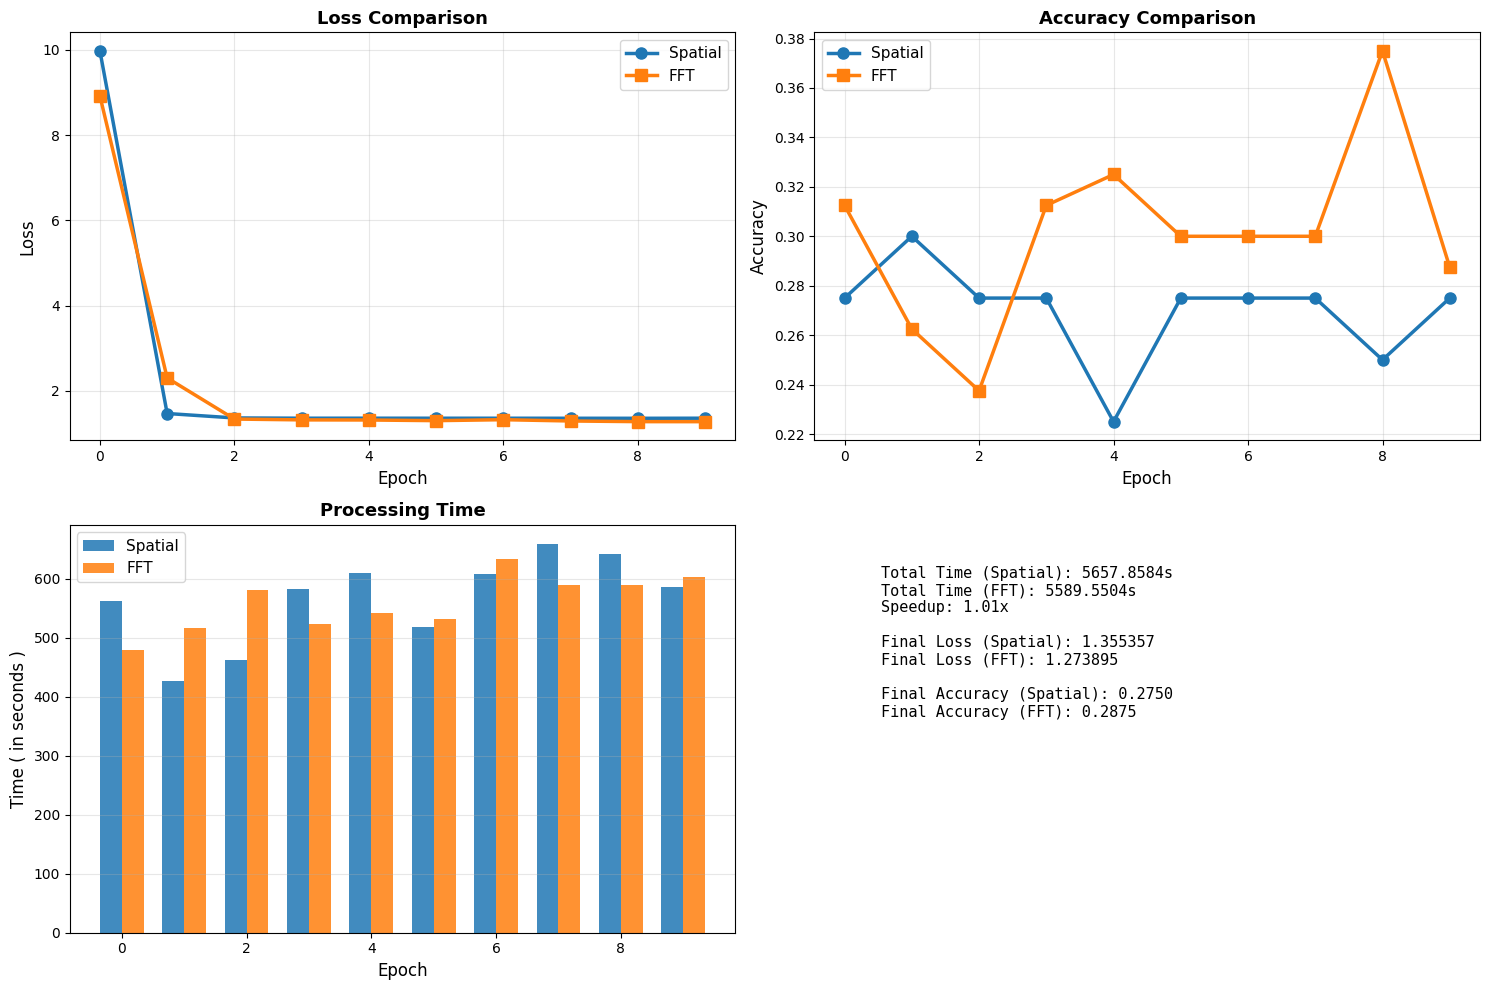

Speedup: 1.01x


In [15]:
# VISUALISASI
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# perbandingan loss
axes[0, 0].plot(loss_spatial, 'o-', label='Spatial', linewidth=2.5, markersize=8, color='#1f77b4')
axes[0, 0].plot(loss_fft, 's-', label='FFT', linewidth=2.5, markersize=8, color='#ff7f0e')
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Loss Comparison', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(alpha=0.3)

# perbandingan accuracy
axes[0, 1].plot(acc_spatial, 'o-', label='Spatial', linewidth=2.5, markersize=8, color='#1f77b4')
axes[0, 1].plot(acc_fft, 's-', label='FFT', linewidth=2.5, markersize=8, color='#ff7f0e')
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy', fontsize=12)
axes[0, 1].set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(alpha=0.3)


x_pos = np.arange(num_epochs)
width = 0.35
axes[1, 0].bar(x_pos - width/2, time_spatial, width, label='Spatial', alpha=0.85, color='#1f77b4')
axes[1, 0].bar(x_pos + width/2, time_fft, width, label='FFT', alpha=0.85, color='#ff7f0e')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Time ( in seconds )', fontsize=12)
axes[1, 0].set_title('Processing Time', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(alpha=0.3, axis='y')

axes[1, 1].axis('off')
speedup = sum(time_spatial) / sum(time_fft) if sum(time_fft) > 0 else 0
summary = f"Total Time (Spatial): {sum(time_spatial):.4f}s\nTotal Time (FFT): {sum(time_fft):.4f}s\nSpeedup: {speedup:.2f}x\n\nFinal Loss (Spatial): {loss_spatial[-1]:.6f}\nFinal Loss (FFT): {loss_fft[-1]:.6f}\n\nFinal Accuracy (Spatial): {acc_spatial[-1]:.4f}\nFinal Accuracy (FFT): {acc_fft[-1]:.4f}"
axes[1, 1].text(0.1, 0.9, summary, transform=axes[1, 1].transAxes, fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print(f"Speedup: {speedup:.2f}x")